In [1]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.utils.extmath import svd_flip
from sklearn.utils import Bunch

from scipy.io import loadmat
from scipy.sparse.linalg import svds

from numpy.linalg import norm
import numpy as np

from torch import Tensor
import torch

from tqdm.auto import trange, tqdm

from skimage import io, img_as_float

import matplotlib.pyplot as plt

import time

In [2]:
X = np.array([[-1, 1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])

In [3]:
pca = PCA(n_components=1)
result = pca.fit_transform(X)
print(result)

[[ 0.50917706]
 [ 2.40151069]
 [ 3.7751606 ]
 [-1.20075534]
 [-2.05572155]
 [-3.42937146]]


In [4]:
def pca_with_eig(X, n):
    # 标准化数据
    X_mean = np.mean(X, axis=0)
    X_std = X - X_mean

    # 计算协方差矩阵
    cov_matrix = np.cov(X_std, rowvar=False)

    # 特征值分解
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # 按特征值降序排列特征向量
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, sorted_indices]

    # 选择前 n 个特征向量
    principal_components = eigenvectors[:, :n]

    # 将数据投影到新的特征空间
    X_pca = np.dot(X_std, principal_components)

    return X_pca


print(pca_with_eig(X, 1))

[[ 0.50917706]
 [ 2.40151069]
 [ 3.7751606 ]
 [-1.20075534]
 [-2.05572155]
 [-3.42937146]]


In [5]:
def pca_with_svd(X, n):
    # 标准化数据
    X_mean = np.mean(X, axis=0)
    X_std = X - X_mean

    # 执行奇异值分解
    U, S, Vt = np.linalg.svd(X_std, full_matrices=False)
    U, Vt = svd_flip(U, Vt)

    # 选择前 n 个特征向量
    principal_components = Vt[:n].T

    # 将数据投影到新的特征空间
    X_pca = np.dot(X_std, principal_components)

    return X_pca


print(pca_with_svd(X, 1))

[[ 0.50917706]
 [ 2.40151069]
 [ 3.7751606 ]
 [-1.20075534]
 [-2.05572155]
 [-3.42937146]]


In [6]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=1)
result = pca.fit_transform(X_scaled)
print(result)

[[-0.01567033]
 [ 1.34064801]
 [ 2.1824706 ]
 [-0.67032401]
 [-0.99765084]
 [-1.83947343]]


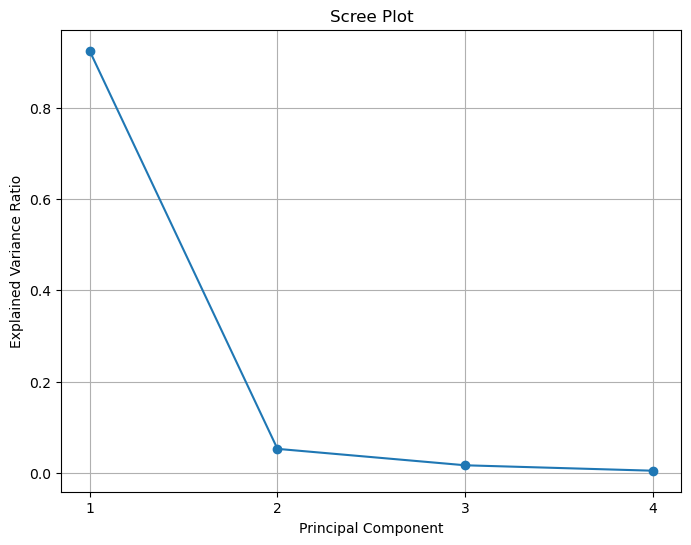

In [7]:
iris: Bunch = load_iris()  # type: ignore
X = iris.data
y = iris.target
pca = PCA()
pca.fit(X)

plt.figure(figsize=(8, 6))
plt.plot(
    range(1, pca.n_components_ + 1),
    pca.explained_variance_ratio_,
    marker="o",
    linestyle="-",
)
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.xticks(range(1, pca.n_components_ + 1))
plt.grid()
plt.show()

In [8]:
def _shrinkage(tau: float, M: Tensor) -> Tensor:
    return M.sign() * torch.maximum(M.abs() - tau, torch.zeros_like(M))


def _singular_value_threshold(tau: float, M: Tensor) -> Tensor:
    u, sigma, v = torch.linalg.svd(M, full_matrices=False)
    return u @ _shrinkage(tau, sigma.diag()) @ v


def robust_pca(
    M: Tensor,
    mu: float = None,  # type: ignore
    lmd: float = None,  # type: ignore
    delta: float = 1e-7,
    max_iter_pass: int = 500,
    devices="cpu",
) -> tuple[Tensor, Tensor]:  # type: ignore
    if not mu:
        mu = (
            torch.prod(torch.tensor(M.shape))
            / (torch.tensor(4) * torch.linalg.vector_norm(M, ord=1))
        ).item()

    if mu <= 0:
        raise ValueError("mu must be a positive number")

    if not lmd:
        lmd = (
            torch.tensor(1) / torch.sqrt(torch.max(torch.tensor(M.shape))).item()
        ).item()

    L = torch.zeros_like(M, device=devices)
    S = torch.zeros_like(M, device=devices)
    Y = torch.zeros_like(M, device=devices)

    stop_boundary = delta * torch.linalg.norm(M, ord="fro")
    frobenius_norm_value = torch.inf

    current_pass = 0
    while current_pass <= max_iter_pass and frobenius_norm_value > stop_boundary:
        current_pass += 1
        L = _singular_value_threshold(1 / mu, M - S + (1 / mu) * Y)
        S = _shrinkage(lmd / mu, M - L + (1 / mu) * Y)
        Y = Y + mu * (M - L - S)
        frobenius_norm_value = torch.linalg.norm(M - L - S, ord="fro")
        # print(f"Current frobenius norm value at {current_pass}: {frobenius_norm_value}")
    return L, S

In [9]:
def shrinkage(S, theta):
    return np.sign(S) * np.maximum(0.0, np.abs(S) - theta)


def LearnedRPCA(model, Y, r, X_star=None):
    ths = model["ths"][0]
    step = model["step"][0]
    n, _ = Y.shape
    zeta = ths * (1000 / n) * (r / 5)
    eta = step
    S = shrinkage(Y, zeta[0])
    U0, Sigma0, V0 = svds(Y - S, r)
    Sigma = np.sqrt(np.diag(Sigma0))

    L = U0 @ Sigma
    R = V0.T @ Sigma
    X = L @ R.T

    for t in trange(zeta.size - 1):
        S = shrinkage(Y - X, zeta[t + 1])
        temp = X + S - Y
        Lgredient = temp @ R
        Rgredient = temp.T @ L
        # Tikhonov regularization
        reg = np.finfo(float).eps * np.eye(r)
        Lscaled = np.linalg.inv(R.T @ R + reg)
        Rscaled = np.linalg.inv(L.T @ L + reg)

        L_plus = L - eta[t + 1] * Lgredient @ Lscaled
        R_plus = R - eta[t + 1] * Rgredient @ Rscaled

        L = L_plus
        R = R_plus
        X = L @ R.T

        if X_star is not None:
            dist_X = norm(X - X_star, "fro") / norm(X_star, "fro")
            tqdm.write(f"Iteration: {t+1}, Err: {dist_X:e}")

    return X, L, R

In [10]:
image = io.imread("./croppedyale/yaleB05/yaleB05_P00A+060E+20.pgm")
image = img_as_float(image)

noisy_image = np.copy(image)
noise_mask = np.random.choice([0, 1, 2], size=image.shape[:2], p=[0.9, 0.05, 0.05])
noisy_image[noise_mask == 1] = 1
noisy_image[noise_mask == 2] = 0

In [11]:
def process_and_time(func, *args, **kwargs):
    start_time = time.time()
    result = func(*args, **kwargs)
    end_time = time.time()
    return result, end_time - start_time

PCA 算法开始
PCA 算法结束
RPCA 算法开始
RPCA 算法结束
LRPCA算法开始


  0%|          | 0/16 [00:00<?, ?it/s]

LRPCA算法结束


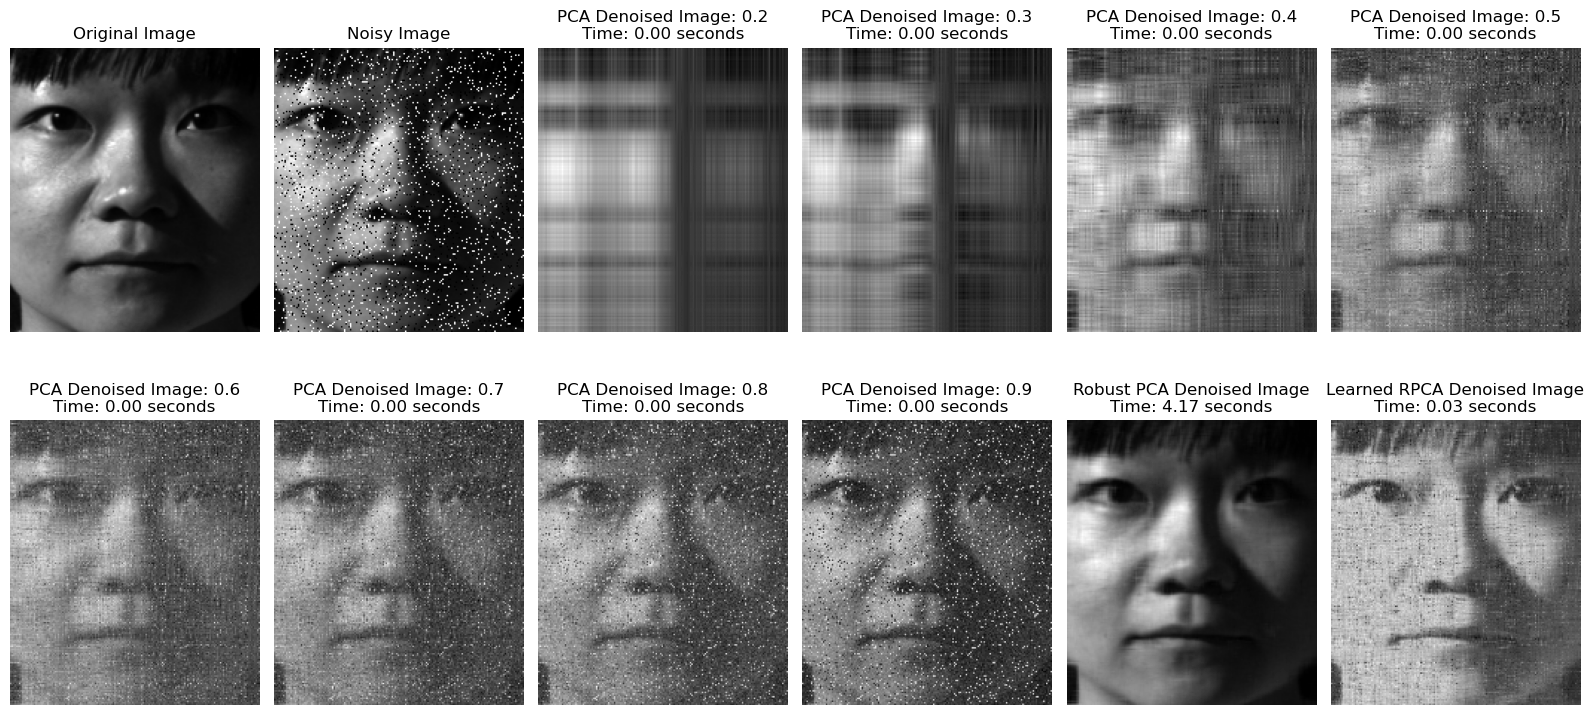

In [12]:
fig, axes = plt.subplots(2, 6, figsize=(16, 8))
ax = axes.ravel()

ax[0].imshow(image, cmap="gray")
ax[0].set_title("Original Image")
ax[0].axis("off")

ax[1].imshow(noisy_image, cmap="gray")
ax[1].set_title("Noisy Image")
ax[1].axis("off")

print("PCA 算法开始")
for n, rate in enumerate([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]):
    pca = PCA(rate)
    filtered_image, processing_time = process_and_time(
        pca.inverse_transform, pca.fit_transform(noisy_image)
    )

    ax[n + 2].imshow(filtered_image, cmap="gray")
    ax[n + 2].set_title(
        f"PCA Denoised Image: {rate}\nTime: {processing_time:.2f} seconds"
    )
    ax[n + 2].axis("off")
print("PCA 算法结束")

print("RPCA 算法开始")
rpca_result, processing_time = process_and_time(
    robust_pca, torch.tensor(noisy_image), max_iter_pass=1000
)
print("RPCA 算法结束")
ax[10].imshow(rpca_result[0], cmap="gray")
ax[10].set_title(f"Robust PCA Denoised Image\nTime: {processing_time:.2f} seconds")
ax[10].axis("off")


print("LRPCA算法开始")
model = loadmat("./lrpca_model/lrpcanet_alpha0.3.mat")
lrpca_result, processing_time = process_and_time(LearnedRPCA, model, noisy_image, 25)
ax[11].imshow(lrpca_result[0], cmap="gray")
ax[11].set_title(f"Learned RPCA Denoised Image\nTime: {processing_time:.2f} seconds")
ax[11].axis("off")
print("LRPCA算法结束")

plt.tight_layout()
plt.show()